# Introduction
We have recieved dataset containing information phishing URLs. Dataset contains list of URLs, URL has SSL, URL allows SQL injection, URL have cert ver, URL allows inp val and whether URL is UNSAFE or not. We'll be dividing dataset into train, validation and test sets. Train set will be used for training and validation set for validation of trained model. We'll then use test set for testing once whole model has completed training.

We'll be trying LSTM and Dense Net for our purpose. We'll first tokenize data using various stratgies like count vectorizer, tfidf, frequency of words etc. We also have used first layer as embedding layer for our LSTM model to create embedding for words.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image ## Library for loading images
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l1, l2
from keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from IPython.display import FileLink
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
We have loaded data in pandas dataframe and then we remove all rows which has any NAN to avoid issues during training.

In [2]:
df = pd.read_csv('csv_result-Phishing_Legitimate_full.csv') ## Change here based on where is file on your local
df = df.dropna() ## Here we are removing any rows which has NaNs. We can't train model with Nan values else it'll fail.
print(df.shape)
df.head() ## Printing first 5 columns of dataset

(10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [3]:
df.tail() ## Printing last 5 columns of dataset.

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
9995,9996,3,1,1,50,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,9997,2,1,4,59,1,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,9998,2,1,4,57,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,9999,3,1,1,49,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
9999,10000,3,1,2,52,3,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0


In [4]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(5,5))
        plt.imshow(conf_mat, cmap=plt.cm.Blues)
        plt.xticks(range(2), range(2))
        plt.yticks(range(2), range(2))
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        plt.savefig('conf_mat.png')

def plot_loss_and_accuracy(hist):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        plt.subplot(122)
        plt.plot(hist.history['accuracy'], label='Train Accuracy')
        plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
        plt.savefig('loss_and_acc.png')
            
def train_and_evaluate_model(model_type, model, loss='binary_crossentropy', optimizer='adam', batch_size=32, epochs=10, validation_split=0.1, figures=False, verbose=0):
    #print('\nCompiling Model')
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) # Compiling Model
    #print('\nTraining Model\n')
    if model_type=='DenseNet':
        hist = model.fit(X_train, Y_train, batch_size=32, epochs=epochs, validation_split=validation_split, verbose=verbose) ## Fitting Model
    else:
        hist = model.fit(X_train.reshape((X_train.shape[0],1,X_train.shape[1])), Y_train, batch_size=32, epochs=epochs, validation_split=validation_split, verbose=verbose) ## Fitting Model
    
    if figures:
        plot_loss_and_accuracy(hist)
        if model_type == 'DenseNet':
            plot_confusion_matrix(Y_test, model.predict_classes(X_test))
        else:
            plot_confusion_matrix(Y_test, model.predict_classes(X_test.reshape((X_test.shape[0],1,X_test.shape[1]))))
        
    ## Evaluating Model
    if model_type == 'DenseNet':
        test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=64, verbose=verbose)
        train_loss, train_acc = model.evaluate(X_train, Y_train, batch_size=64, verbose=verbose)
    else:
        test_loss, test_acc = model.evaluate(X_test.reshape((X_test.shape[0],1,X_test.shape[1])), Y_test, batch_size=64, verbose=verbose)
        train_loss, train_acc = model.evaluate(X_train.reshape((X_train.shape[0],1,X_train.shape[1])), Y_train, batch_size=64, verbose=verbose)
    print('\nTest Loss: %.3f'%test_loss)
    print('Train Loss: %.3f'%train_loss)
    print('Test accuracy: %.2f'%(test_acc*100))
    print('Train accuracy: %.2f'%(train_acc*100))
    return test_loss, test_acc, train_loss, train_acc

# 2. LSTM Model v2
Below we have defined our second LSTM model. Our model consist of 4 layers(3 LSTM & 1 Dense). LSTM layers consist of 32 units. Here units generally refers to that many nodes in that layers. Dropout are introduced to prevent model from overfitting. Dropout of 0.2 ignores 20% of outputs and set them to 0 before giving it as input to next layer. Dense layer consist of 1 unit with activation function as sigmoid which will transfer LSTM’s output in range (0,1.0) which is probability of that sample. Probability >0.5 will predict output as 1 and <=0.5 will predict output as 0.

LSTM layer’s units are used to store stateful information in it. We have kept 32 units which will help it store information. Due to 32 units, it requires 10,368 parameters which are calculated as follows. ((input_size + units + 1) input_size) 4 = ((48 + 32 + 1 )32) 4 = 10,386. Here parameters refers to that many weights will be trained for layer to store information.

Dense layer is simple linear layer which has 33 parameter and single output. Sigmoid activation function transfers output of LSTM from shape of (batch_size,33) to (batch_size,1) which is 1 prediction for all samples of batch. Here Dense layer has 33 parameters because it takes as input 32 units of LSTM layer and 1 bias parameter.

Total Parameters are LSTM + Dense = 10,386 + 33 = 10,401 All parameters are trainable. We don’t have singel parameter which does not need training. We need to train all.

Below we have printed summary of our model which shows layers and their shapes along with parameters that particular layer will train as well as whole model.

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 32)             10368     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 27,041
Trainable params: 27,041
Non-trainable params: 0
_________________________________________________________________
None


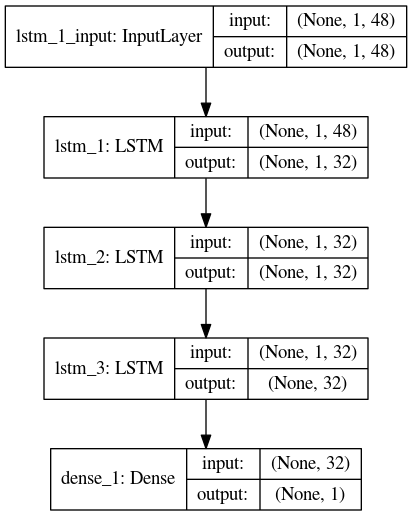

In [5]:
print('Build model...')
def create_lstm_v2(activation='relu', units=32, dropout=0.25, kernel_regularizer=None, kernel_initializer='glorot_uniform'):
    return Sequential([
                LSTM(units=units, activation=activation, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, return_sequences= True, dropout=dropout, recurrent_dropout=0.2, input_shape=(1,48)),
                LSTM(units=units, activation=activation, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, return_sequences=True),
                LSTM(units=units, activation=activation, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer,),
                Dense(1, activation='sigmoid')
                ])

model = create_lstm_v2()
print(model.summary())
plot_model(model, to_file='lstm_modelv2.png', show_shapes=True)
Image.open('lstm_modelv2.png')

## 2.1 Splitting Dataset into Train/Test Sets (80%-20%)

In [6]:
X = df.drop(['id','CLASS_LABEL'], axis=1).values ## We are taking all columns except id and class_label as features of model.
Y = df[['CLASS_LABEL']].values ## We are taking class label as target variable.

## We are dividing dataset into train and test sets. Here random_state=123 refers to it'll produce same split each making it reproducible.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, stratify=Y, random_state=123) 
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (8000, 48) (2000, 48) (8000, 1) (2000, 1)


## 2.1.1 Trying Default Model

Train on 7200 samples, validate on 800 samples
Epoch 1/10
7200/7200 [==============================] - 2s 336us/step - loss: 0.5763 - accuracy: 0.7089 - val_loss: 0.3207 - val_accuracy: 0.8938
Epoch 2/10
7200/7200 [==============================] - 1s 138us/step - loss: 0.3423 - accuracy: 0.8537 - val_loss: 0.2152 - val_accuracy: 0.9237
Epoch 3/10
7200/7200 [==============================] - 1s 136us/step - loss: 0.3146 - accuracy: 0.8683 - val_loss: 0.2195 - val_accuracy: 0.9187
Epoch 4/10
7200/7200 [==============================] - 1s 138us/step - loss: 0.2971 - accuracy: 0.8768 - val_loss: 0.2029 - val_accuracy: 0.9300
Epoch 5/10
7200/7200 [==============================] - 1s 132us/step - loss: 0.2762 - accuracy: 0.8811 - val_loss: 0.1969 - val_accuracy: 0.9225
Epoch 6/10
7200/7200 [==============================] - 1s 134us/step - loss: 0.2718 - accuracy: 0.8824 - val_loss: 0.1966 - val_accuracy: 0.9287
Epoch 7/10
7200/7200 [==============================] - 1s 137us/step - loss:

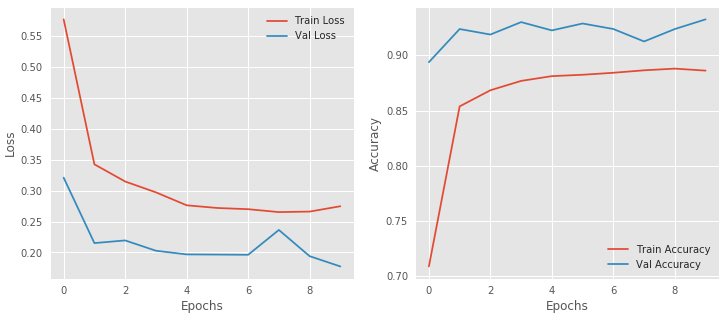

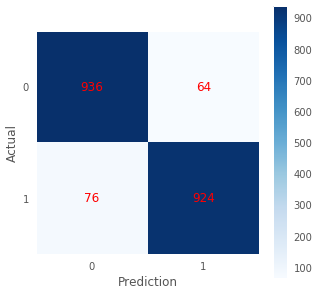

In [7]:
lstm_v2 = create_lstm_v2()
test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v2, figures=True, verbose=1)

## 2.1.2 Trying Various Hyperparameter Settings, activation funcs, loss functions, dropouts, etc

In [8]:
%%time

results = []
for activation in ['relu', 'tanh']:
    for unit in [32,50]:
        for dropout in [0.25,0.30,0.50]:
            for opt in ['adam', 'rmsprop']:
                for kernel_regularizer in  ['l1', 'l2']:
                    for kernel_initializer in ['glorot_uniform','random_uniform']:
                        print('\nActivation : %s, Units : %d, Dropout : %.2f, Optimizer : %s, Regularization : %s, Weights Inits : %s'%(activation, unit, dropout, opt, kernel_regularizer, kernel_initializer))
                        lstm_v2 = create_lstm_v2(activation=activation, units=unit, dropout=dropout, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer)
                        test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v2, optimizer=opt)
                        results.append([activation, unit, dropout, opt, kernel_regularizer, kernel_initializer, test_loss, test_acc, train_loss, train_acc])


Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.711
Train Loss: 0.711
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : random_uniform

Test Loss: 0.711
Train Loss: 0.711
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : glorot_uniform

Test Loss: 0.276
Train Loss: 0.259
Test accuracy: 92.45
Train accuracy: 93.16

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : random_uniform

Test Loss: 0.693
Train Loss: 0.693
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : rmsprop, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.764
Train Loss: 0.764
Test accuracy: 50.00
Train accuracy: 50.00

Activation 

## 2.1.3 Displaying All Hyperparamters Combination Results as DataFrame

In [9]:
df3 = pd.DataFrame(results, columns=['Activation', 'Units', 'Dropout', 'Optimizer', 'Regularization', 'Weights Inits','Test Loss','Test Accuracy','Train Loss', 'Train Accuracy'])
df3.sort_values(by='Test Accuracy')

,Activation,Units,Dropout,Optimizer,Regularization,Weights Inits,Test Loss,Test Accuracy,Train Loss,Train Accuracy
0,relu,32,0.25,adam,l1,glorot_uniform,0.711208,0.5000,0.711208,0.500000
69,tanh,32,0.50,rmsprop,l1,random_uniform,0.761150,0.5000,0.761150,0.500000
68,tanh,32,0.50,rmsprop,l1,glorot_uniform,0.763964,0.5000,0.763964,0.500000
67,tanh,32,0.50,adam,l2,random_uniform,0.693179,0.5000,0.693179,0.500000
66,tanh,32,0.50,adam,l2,glorot_uniform,0.693163,0.5000,0.693163,0.500000
...,...,...,...,...,...,...,...,...,...,...
14,relu,32,0.30,rmsprop,l2,glorot_uniform,0.325045,0.9050,0.308983,0.911500
30,relu,50,0.25,rmsprop,l2,glorot_uniform,0.299825,0.9095,0.284592,0.923750
10,relu,32,0.30,adam,l2,glorot_uniform,0.307590,0.9195,0.295560,0.921625
26,relu,50,0.25,adam,l2,glorot_uniform,0.293135,0.9235,0.277888,0.927500


## 2.2 Splitting Dataset into Train/Test Sets (70%-30%)

In [10]:
X = df.drop(['id','CLASS_LABEL'], axis=1).values ## We are taking all columns except id and class_label as features of model.
Y = df[['CLASS_LABEL']].values ## We are taking class label as target variable.

## We are dividing dataset into train and test sets. Here random_state=123 refers to it'll produce same split each making it reproducible.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, stratify=Y, random_state=123) 
print('Train/Test Sizes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (7000, 48) (3000, 48) (7000, 1) (3000, 1)


## 2.2.1 Trying Default Model

Train on 6300 samples, validate on 700 samples
Epoch 1/10
6300/6300 [==============================] - 12s 2ms/step - loss: 0.6167 - accuracy: 0.6452 - val_loss: 0.3745 - val_accuracy: 0.8900
Epoch 2/10
6300/6300 [==============================] - 2s 373us/step - loss: 0.3930 - accuracy: 0.8354 - val_loss: 0.2542 - val_accuracy: 0.9043
Epoch 3/10
6300/6300 [==============================] - 2s 375us/step - loss: 0.3144 - accuracy: 0.8659 - val_loss: 0.2405 - val_accuracy: 0.9086
Epoch 4/10
6300/6300 [==============================] - 2s 386us/step - loss: 0.3031 - accuracy: 0.8684 - val_loss: 0.2232 - val_accuracy: 0.9143
Epoch 5/10
6300/6300 [==============================] - 2s 378us/step - loss: 0.2796 - accuracy: 0.8837 - val_loss: 0.2018 - val_accuracy: 0.9171
Epoch 6/10
6300/6300 [==============================] - 2s 322us/step - loss: 0.2837 - accuracy: 0.8841 - val_loss: 0.2021 - val_accuracy: 0.9286
Epoch 7/10
6300/6300 [==============================] - 2s 364us/step - loss: 

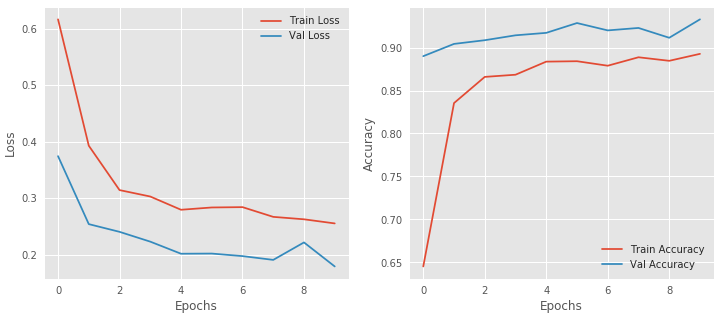

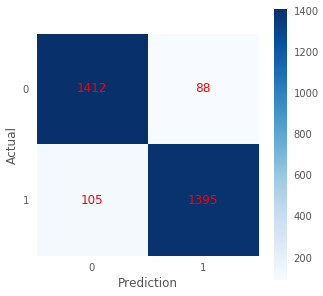

In [11]:
lstm_v2 = create_lstm_v2()
test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v2, figures=True, verbose=1)

## 2.2.2 Trying Various Hyperparameter Settings, activation funcs, loss functions, dropouts, etc

In [12]:
%%time

results = []
for activation in ['relu', 'tanh']:
    for unit in [32,50]:
        for dropout in [0.25,0.30,0.50]:
            for opt in ['adam', 'rmsprop']:
                for kernel_regularizer in  ['l1', 'l2']:
                    for kernel_initializer in ['glorot_uniform','random_uniform']:
                        print('\nActivation : %s, Units : %d, Dropout : %.2f, Optimizer : %s, Regularization : %s, Weights Inits : %s'%(activation, unit, dropout, opt, kernel_regularizer, kernel_initializer))
                        lstm_v2 = create_lstm_v2(activation=activation, units=unit, dropout=dropout, kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer)
                        test_loss, test_acc, train_loss, train_acc = train_and_evaluate_model('LSTM', lstm_v2, optimizer=opt)
                        results.append([activation, unit, dropout, opt, kernel_regularizer, kernel_initializer, test_loss, test_acc, train_loss, train_acc])


Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.711
Train Loss: 0.711
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l1, Weights Inits : random_uniform

Test Loss: 0.711
Train Loss: 0.711
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : glorot_uniform

Test Loss: 0.351
Train Loss: 0.353
Test accuracy: 88.57
Train accuracy: 88.34

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : adam, Regularization : l2, Weights Inits : random_uniform

Test Loss: 0.693
Train Loss: 0.693
Test accuracy: 50.00
Train accuracy: 50.00

Activation : relu, Units : 32, Dropout : 0.25, Optimizer : rmsprop, Regularization : l1, Weights Inits : glorot_uniform

Test Loss: 0.764
Train Loss: 0.764
Test accuracy: 50.00
Train accuracy: 50.00

Activation 

## 2.2.3 Displaying All Hyperparamters Combination Results as DataFrame

In [13]:
df4 = pd.DataFrame(results, columns=['Activation', 'Units', 'Dropout', 'Optimizer', 'Regularization', 'Weights Inits','Test Loss','Test Accuracy','Train Loss', 'Train Accuracy'])
df4.sort_values(by='Test Accuracy')

,Activation,Units,Dropout,Optimizer,Regularization,Weights Inits,Test Loss,Test Accuracy,Train Loss,Train Accuracy
0,relu,32,0.25,adam,l1,glorot_uniform,0.711124,0.500000,0.711124,0.500000
69,tanh,32,0.50,rmsprop,l1,random_uniform,0.761755,0.500000,0.761755,0.500000
68,tanh,32,0.50,rmsprop,l1,glorot_uniform,0.763652,0.500000,0.763652,0.500000
67,tanh,32,0.50,adam,l2,random_uniform,0.693153,0.500000,0.693153,0.500000
66,tanh,32,0.50,adam,l2,glorot_uniform,0.693162,0.500000,0.693162,0.500000
...,...,...,...,...,...,...,...,...,...,...
6,relu,32,0.25,rmsprop,l2,glorot_uniform,0.306145,0.912667,0.298006,0.918429
38,relu,50,0.30,rmsprop,l2,glorot_uniform,0.295931,0.916667,0.292565,0.924714
30,relu,50,0.25,rmsprop,l2,glorot_uniform,0.288831,0.919000,0.280765,0.926571
10,relu,32,0.30,adam,l2,glorot_uniform,0.308394,0.920333,0.303244,0.922571


## Saving All Outputs to Excel & Presenting as Link to Download

In [14]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('LSTMv2_1', df3), ('LSTMv2_2', df4)]:
        df.to_excel(writer, sheet_name= sheet_name)

In [15]:
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx